# Aquifer

Here we will follow [Petrowiki](petrowiki.sp.org)'s [History matching water influx](https://petrowiki.spe.org/Water_influx_models#Example:_History_matching_water_influx) example, using _pywaterflood_


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pywaterflood.aquifer import (
    aquifer_production,
    effective_reservoir_radius,
)

[(0.0, 1702.0), Text(0, 0.5, 'pressure, psi'), Text(0.5, 0, 'Time (years)')]

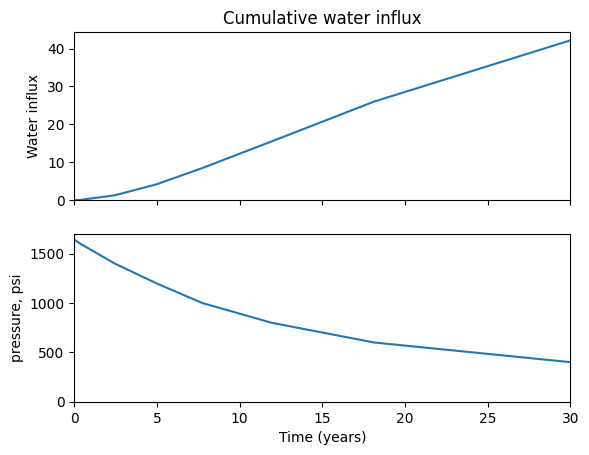

In [2]:
influx_table = pd.DataFrame(
    {
        "j": range(1, 9),
        "time": [0, 0.368, 2.439, 4.957, 7.732, 11.926, 18.126, 30.044],
        "pressure": [1640.0, 1600, 1400, 1200, 1000, 800, 600, 400],
        "cum_water_influx": [0.0, 0.062, 1.272, 4.156, 8.455, 15.494, 26.014, 42.243],
    }
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
influx_table.plot(x="time", y="cum_water_influx", ax=ax1, legend=False)
influx_table.plot(x="time", y="pressure", ax=ax2, legend=False)
ax1.set(xlim=(0, 30), ylim=(0, None), ylabel="Water influx", title="Cumulative water influx")
ax2.set(ylim=(0, None), ylabel="pressure, psi", xlabel="Time (years)")

According to the table, the pore volume is 385 MMrb, porosity is 31%, thickness is 20 ft, and the reservoir is semicircular (180 deg). Plugging these into the handy equation gets to $r_o$, the effective reservoir radius


In [3]:
phi = 0.31
V_pr = 385
r_reservoir = effective_reservoir_radius(V_pr, phi, 20, 180)

with this in hand, the next step is calculating $t_D$, $U$, and $\Delta p$.

$$
t_D = k_t t\\
k_t = \frac{2.309 k_a }{\phi_a \mu_w c_t r_o^2}\\
U = V_{pa}c_t
$$


In [4]:
k_a = 64.2
mu = 0.48
c_t = 5.88
phi_a = 0.27
k_t = 2.309 * k_a / (phi_a * mu * c_t * r_reservoir**2)
aquifer_constant = 1.119 * 8.7 * r_reservoir**2 * phi * c_t / 1e6
influx_table = influx_table.assign(t_D=lambda x: k_t * x.time)

Now all the numbers are together to calculate the predicted cumulative production over time. This uses the `aquifer_production` function from pywaterflood. Replicating their Table 4 and Figure 7 is a synch:

,j,time,pressure,cum_water_influx,t_D,pressure_ave,pressure_delta,Sigma Delta p W_D,W_e
0,1,0.000,1640.0,0.000,0.000000,1640.0,0.0,0.000000,0.000000
1,2,0.368,1600.0,0.062,0.322520,1620.0,20.0,17.077578,0.067264
2,3,2.439,1400.0,1.272,2.137571,1500.0,120.0,342.000495,1.347048
3,4,4.957,1200.0,4.156,4.344378,1300.0,200.0,1113.570830,4.386056
4,5,7.732,1000.0,8.455,6.776423,1100.0,200.0,2249.182040,8.858923
5,6,11.926,800.0,15.494,10.452098,900.0,200.0,4130.715726,16.269779
6,7,18.126,600.0,26.014,15.885856,700.0,200.0,6801.264932,26.788354
7,8,30.044,400.0,42.243,26.330942,500.0,200.0,10774.726901,42.438753


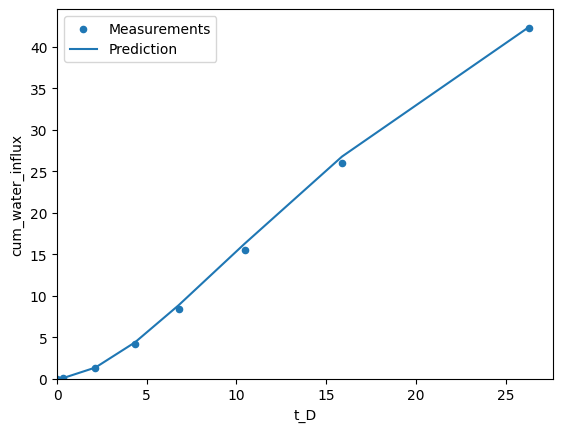

In [5]:
influx_table = influx_table.assign(
    pressure_ave=lambda x: x.pressure.rolling(2, min_periods=1).mean(),
    pressure_delta=lambda x: (-x.pressure_ave.diff(1)).fillna(0),
)
r_ed = 5
w_ek = aquifer_production(
    influx_table["pressure_delta"],
    influx_table["t_D"],
    r_ed=r_ed,
    method="klins",
    aquifer_constant=aquifer_constant,
)
influx_table["Sigma Delta p W_D"] = w_ek / aquifer_constant
influx_table["W_e"] = w_ek

ax = plt.axes()
influx_table.plot(x="t_D", y="cum_water_influx", kind="scatter", label="Measurements", ax=ax)
influx_table.plot("t_D", "W_e", label="Prediction", ax=ax)
ax.set(xlim=(0, None), ylim=(0, None))
ax.legend()
influx_table

Writing an optimizer to find $r_{eD}$ and $U$ is also acheivable, using scipy's optimize.

r_ed_fit=5.12, u_fit=0.0038


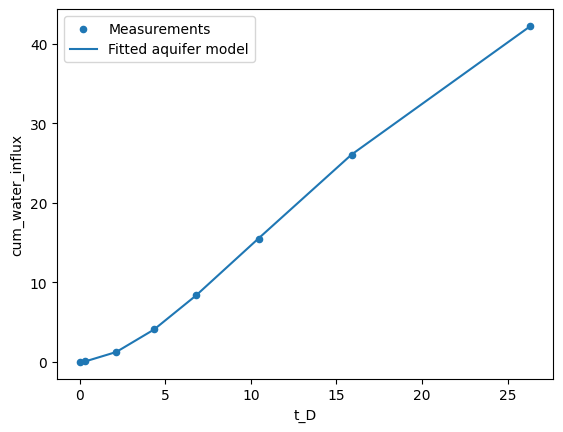

In [6]:
from scipy.optimize import curve_fit

(r_ed_fit, u_fit), _ = curve_fit(
    lambda x, *p: aquifer_production(
        influx_table["pressure_delta"], x, p[0], "marsal-walsh", p[1]
    ),
    xdata=influx_table["t_D"],
    ydata=influx_table["cum_water_influx"],
    p0=[1.2, 1e-3],
    bounds=[(1.01, 0), (np.inf, np.inf)],
)

ax = plt.axes()
influx_table.plot(x="t_D", y="cum_water_influx", kind="scatter", label="Measurements", ax=ax)
ax.plot(
    influx_table["t_D"],
    aquifer_production(
        influx_table["pressure_delta"], influx_table["t_D"], r_ed_fit, "marsal-walsh", u_fit
    ),
    label="Fitted aquifer model",
)
ax.legend()
print(f"{r_ed_fit=:.2f}, {u_fit=:.2g}")  # noqa: T201